# Aphid-Ladybeetle study

In [1]:
import matplotlib.pyplot as plt
from numba import jit
import numpy as np  # linear algebra
from scipy.integrate import solve_ivp  # to solve ODE system
from scipy import optimize
import pandas as pd

np.seterr('warn')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Obtaining Initial Conditions

We need to define Initial Conditions as functions in order to define them for each discretization point. Here we will fit ICs as polynomial functions.

Loading data:

In [2]:
data_dir = "../data/simple/local/"
aphid_data = pd.read_excel(data_dir + 'aphid.xls')
ladybeetle_data = pd.read_excel(data_dir + 'ladybeetle.xls')

In [3]:
aphid_data

,variable,time,density
0,aphid,0,83.879889
1,aphid,1,77.611940
2,aphid,4,85.074627
3,aphid,8,73.134328


In [4]:
ladybeetle_data

,variable,time,density
0,ladybeetle,0,2.677953
1,ladybeetle,1,3.066667
2,ladybeetle,4,0.959699
3,ladybeetle,8,1.400000


Retrieving IC data:

In [5]:
aphid_ic = aphid_data[aphid_data.time == 0].density.values[0]
ladybeetle_ic = ladybeetle_data[ladybeetle_data.time == 0].density.values[0]

In [6]:
aphid_ic

83.87988937178977

In [7]:
ladybeetle_ic

2.6779525032092426

In [8]:
y0_PPRM = aphid_ic, ladybeetle_ic

y0_PPRM

(83.87988937178977, 2.6779525032092426)

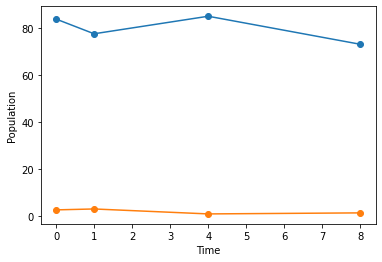

In [9]:
import matplotlib.pyplot as plt

plt.plot(aphid_data.time.values, aphid_data.density.values, '-o')
plt.plot(ladybeetle_data.time.values, ladybeetle_data.density.values, '-o')
plt.xlabel('Time')
plt.ylabel('Population')
plt.show()

# Prey-Predator Rosenzweig-MacArthur model

In [10]:
@jit(nopython=True)
def PPRM_model(
    t,
    X,
    r=1,
    K=10,
    a=1,
    h=1,
    ef=1,
    m=1,
):
    """
    Prey-Predator Rosenzweig-MacArthur (PPRM) python implementation.
    """
    u, v = X
    u_prime = r * u * ( 1 - u / K ) - a * u * v / ( 1 + a * h * u )
    v_prime = ef * a * u * v / ( 1 + a * h * u ) - m * v
    return u_prime, v_prime

def PPRM_ode_solver(
    y0,
    t_span,
    t_eval,
    r=1,
    K=10,
    a=1,
    h=1,
    ef=1,
    m=1,
):
    solution_ODE = solve_ivp(
        fun=PPRM_model,
        t_span=t_span,
        y0=y0,
        t_eval=t_eval,
        args=(r, K, a, h, ef, m),
        method="LSODA",
    )
    return solution_ODE

* We now need to calibrate the parameters of the function. Firstly, we have to define a least-squares residual error function:

In [11]:
def PPRM_least_squares_error_ode(
    par, time_exp, f_exp, fitting_model, initial_conditions
):
    args = par
    f_exp1, f_exp2 = f_exp
    time_span = (time_exp.min(), time_exp.max())

    weighting_for_exp1_constraints = 1
    weighting_for_exp2_constraints = 1e1
    num_of_qoi = len(f_exp)

    try:
        y_model = fitting_model(initial_conditions, time_span, time_exp, *args)
        simulated_time = y_model.t
        simulated_ode_solution = y_model.y
        simulated_qoi1, simulated_qoi2 = simulated_ode_solution

        residual1 = f_exp1 - simulated_qoi1
        residual2 = f_exp2 - simulated_qoi2

        first_term = weighting_for_exp1_constraints * np.sum(residual1 ** 2.0)
        second_term = weighting_for_exp2_constraints * np.sum(residual2 ** 2.0)

        objective_function = 1 / num_of_qoi * (first_term + second_term)
    except ValueError:
        objective_function = 1e15

    return objective_function

* Now we calibrate minimizing the residual applying the Differential Evolution method, a global optimization method, provided by `scipy`:

In [12]:
%%time
def callback_de(xk, convergence):
    """
    This function is to show the optimization procedure progress.
    """
    print(f'parameters = {xk}\n')

bounds_PPRM = [
    (1e-10, 4),  # r
    (1e-10, 4),  # K
    (1e-10, 4),  # a
    (1e-10, 4),  # h
    (1e-10, 4),  # ef
    (1e-10, 4),  # m
]

result_PPRM = optimize.differential_evolution(
    PPRM_least_squares_error_ode,
    bounds=bounds_PPRM,
    args=(
        aphid_data.time.values,
        [aphid_data.density.values, ladybeetle_data.density.values],
        PPRM_ode_solver,
        y0_PPRM,
    ),
    popsize=30,
    strategy="best1bin",
    tol=1e-5,
    recombination=0.95,
    mutation=0.6,
    maxiter=2000,
    polish=True,
    disp=True,
    seed = 1234,  # for the sake of reproducibility
    callback=callback_de,
    workers=-1,
)

print(result_PPRM)

/home/diego/pdeco/.env/lib/python3.8/site-packages/scipy/optimize/_differentialevolution.py:495: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  warnings.warn("differential_evolution: the 'workers' keyword has"


differential_evolution step 1: f(x)= 4379.33
parameters = [0.02836587 2.94545287 2.77381098 2.79155603 1.53124016 3.26327081]

differential_evolution step 2: f(x)= 1598.17
parameters = [0.00618026 2.5781815  2.17644762 2.42064717 0.97476208 2.72286613]

differential_evolution step 3: f(x)= 381.028
parameters = [2.03127058e-03 2.58397409e+00 2.25025598e+00 2.84158721e+00
 1.43022676e+00 2.83150606e+00]

differential_evolution step 4: f(x)= 252.31
parameters = [1.10444516e-03 1.87132241e+00 3.53119394e+00 2.82883035e+00
 1.78172724e+00 3.15723027e+00]

differential_evolution step 5: f(x)= 252.31
parameters = [1.10444516e-03 1.87132241e+00 3.53119394e+00 2.82883035e+00
 1.78172724e+00 3.15723027e+00]

differential_evolution step 6: f(x)= 252.31
parameters = [1.10444516e-03 1.87132241e+00 3.53119394e+00 2.82883035e+00
 1.78172724e+00 3.15723027e+00]

differential_evolution step 7: f(x)= 150.052
parameters = [8.49141645e-04 2.05167136e+00 2.38790308e+00 2.71877522e+00
 2.88426899e+00 3.0310

differential_evolution step 56: f(x)= 37.9622
parameters = [1.36193305e-05 1.26869238e-01 1.26411759e-02 3.99801549e+00
 2.54536936e-01 1.70211528e-01]

differential_evolution step 57: f(x)= 37.9622
parameters = [1.36193305e-05 1.26869238e-01 1.26411759e-02 3.99801549e+00
 2.54536936e-01 1.70211528e-01]

differential_evolution step 58: f(x)= 37.9622
parameters = [1.36193305e-05 1.26869238e-01 1.26411759e-02 3.99801549e+00
 2.54536936e-01 1.70211528e-01]

differential_evolution step 59: f(x)= 37.9622
parameters = [1.36193305e-05 1.26869238e-01 1.26411759e-02 3.99801549e+00
 2.54536936e-01 1.70211528e-01]

differential_evolution step 60: f(x)= 37.9622
parameters = [1.36193305e-05 1.26869238e-01 1.26411759e-02 3.99801549e+00
 2.54536936e-01 1.70211528e-01]

differential_evolution step 61: f(x)= 37.9622
parameters = [1.36193305e-05 1.26869238e-01 1.26411759e-02 3.99801549e+00
 2.54536936e-01 1.70211528e-01]

differential_evolution step 62: f(x)= 37.9622
parameters = [1.36193305e-05 1.26869

     fun: 37.130246528056766
     jac: array([1.61014329e+04, 5.28169863e-01, 3.70578612e+02, 0.00000000e+00,
       2.13162820e-06, 1.37148959e-02])
 message: 'Optimization terminated successfully.'
    nfev: 20080
     nit: 109
 success: True
       x: array([4.47632117e-06, 2.69832632e-02, 7.83841698e-08, 3.99418953e+00,
       8.85900679e-01, 1.19353896e-01])
CPU times: user 3.42 s, sys: 365 ms, total: 3.78 s
Wall time: 13.7 s


* Retrieving the calibrated parameter values:

In [13]:
t0 = aphid_data.time.values.min()
tf = aphid_data.time.values.max()
days_to_forecast = 0
time_range = np.linspace(t0, tf + days_to_forecast, 100)
(
    r_deterministic,
    K_deterministic,
    a_deterministic,
    h_deterministic,
    ef_deterministic,
    m_deterministic,
) = result_PPRM.x

solution_ODE_PPRM = PPRM_ode_solver(
    y0_PPRM, 
    (t0, tf + days_to_forecast), 
    time_range, 
    *result_PPRM.x
)
t_computed_PPRM, y_computed_PPRM = solution_ODE_PPRM.t, solution_ODE_PPRM.y
u_PPRM, v_PPRM = y_computed_PPRM

parameters_dict = {
    "Model": "PPRM",
    u"$r$": r_deterministic,
    u"$K$": K_deterministic,
    u"$a$": a_deterministic,
    u"$h$": h_deterministic,
    u"$ef$": ef_deterministic,
    u"$m$": m_deterministic,
}

df_parameters_calibrated = pd.DataFrame.from_records([parameters_dict])
print(df_parameters_calibrated.to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
Model &       \$r\$ &       \$K\$ &           \$a\$ &      \$h\$ &      \$ef\$ &       \$m\$ \\
\midrule
 PPRM &  0.000004 &  0.026983 &  7.838417e-08 &  3.99419 &  0.885901 &  0.119354 \\
\bottomrule
\end{tabular}



#### Simulation

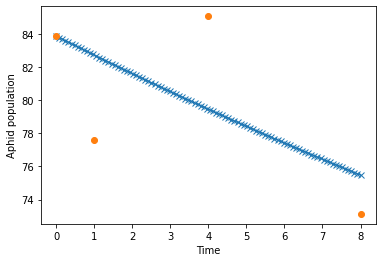

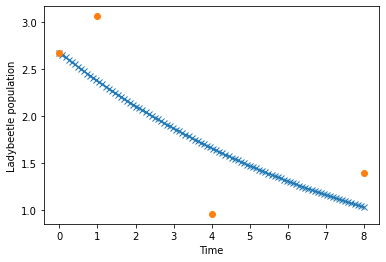

In [14]:
import matplotlib.pyplot as plt

aphid_observed = aphid_data[:].copy()
ladybeetle_observed = ladybeetle_data[:].copy()

plt.plot(t_computed_PPRM, u_PPRM, '-x')
plt.plot(aphid_data.time.values, aphid_observed.density.values, 'o', label='Observed')

plt.xlabel('Time')
plt.ylabel('Aphid population')
plt.show()

plt.plot(t_computed_PPRM, v_PPRM, '-x')
plt.plot(ladybeetle_data.time.values, ladybeetle_observed.density.values, 'o', label='Observed')
plt.xlabel('Time')
plt.ylabel('Ladybeetle population')
plt.show()

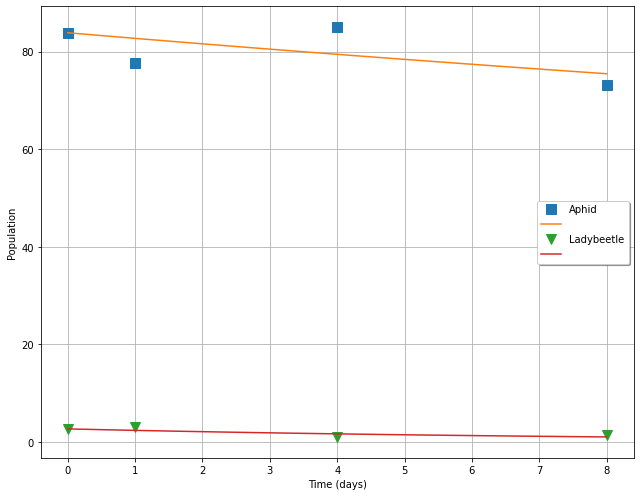

In [15]:
plt.figure(figsize=(9, 7))

plt.plot(
    aphid_data.time.values, aphid_data.density.values, label="Aphid", marker="s", linestyle="", markersize=10
)
plt.plot(t_computed_PPRM, u_PPRM, label=" ")

plt.plot(
    ladybeetle_data.time.values, ladybeetle_data.density.values, label="Ladybeetle", marker="v", linestyle="", markersize=10
)
plt.plot(t_computed_PPRM, v_PPRM, label=" ")

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend(fancybox=True, shadow=True)
plt.grid()

plt.tight_layout()
plt.savefig("PPRM_deterministic_calibration.png")
plt.show()